# Self-Attentive Knowledge Tracing (SAKT)

This model is based on the paper called *Self-Attentive Models for Knowledge Tracing* by Pandey & Karypis (2019). The model is a self-attentive neural network that uses attention mechanisms to capture the relationships between different questions and the knowledge states of students. The model is designed to predict the probability of a student answering a question correctly based on their previous interactions with other questions.

**Outline:**
1. **Introduction**
2. **Imports & Data Loading**  
3. **Data Preprocessing** 
4. **Sequence Generator**  
5. **Build SAKT Model**  
6. **Training Loop**  
7. **Validation**  
8. **Test Set Evaluation**  
9. **Analysis & Visualization**  
10. **Conclusion**

In [ ]:
# Install required libraries (uncomment if running outside Docker)
# !pip install --quiet -r requirements_colab.txt

## 1. Introduction

SAKT is a transformer-style model for **Knowledge Tracing**, first proposed by Pandey & Karypis (2019). Unlike RNN-based approaches (DKT, DKVMN), SAKT relies entirely on **self-attention** to model a student’s evolving mastery of concepts.  

### What is an Attention Mechanism?  
Attention allows a model to “focus” on the most relevant parts of a sequence when making a prediction. It answers:

- “Which past interactions should I attend to in order to predict the next response?”

In **self-attention**, each element in the same sequence (e.g. the student’s interaction history) serves simultaneously as both the **query** and the **keys/values**, enabling the model to learn internal dependencies:

$$
\mathrm{Attention}(Q,\,K,\,V) \;=\;\mathrm{softmax}\Bigl(\tfrac{Q\,K^\top}{\sqrt{d_k}}\Bigr)\;V
$$

- $Q$ (queries): vector representations of the **current** element  
- $K$ (keys): vector representations of **all** elements we might attend to  
- $V$ (values): the information we will combine, weighted by attention  
- $d_k$: scaling factor (the dimension of the key vectors) to stabilize gradients  

The output is a weighted sum of the $V$ vectors, where each weight reflects the compatibility $\tfrac{QK^\top}{\sqrt{d_k}}$.


### Key Components of Transformers (and SAKT)

1. **Embedding Layer**  
   Transforms discrete IDs into dense vectors of dimension $d$.  
   - **Exercise embedding**: $E \in \mathbb{R}^{|\mathcal{Q}|\times d}$  
   - **Interaction embedding**: $M \in \mathbb{R}^{2|\mathcal{Q}|\times d}$  
   where $|\mathcal{Q}|=E$ is the number of distinct questions, and $2E$ encodes “question + correct/incorrect.”

2. **Positional Encoding**  
   Self-attention alone is **permutation-invariant**—it does not know the order of elements. We add a position vector to each embedding:
   $$
     P_{\text{pos}} \;\in\;\mathbb{R}^{\text{max\_len}\times d}
   $$
   - **Learnable** in SAKT: $P[\text{pos}]$ is updated during training.  
   - (In vanilla Transformer one can also use fixed sin/cos formulas.)

3. **Self-Attention Layer**  
   Each time step attends to all **previous** steps (causal masking prevents peeking ahead). For SAKT:  
   - The **query** is the embedding of the next question $e_{t+1}$.  
   - The **keys/values** are the embeddings of past interactions up to $t$.  
   - The attention weights $a_{ij}$ quantify how much the $j$th past interaction influences the next response.

4. **Multi-Head Attention**  
   Rather than a single attention computation, we use $h$ parallel heads:
   $$
     \text{head}_i = \mathrm{Attention}\bigl(QW^Q_i,\;K W^K_i,\;V W^V_i\bigr), 
     \quad
     \text{MultiHead} = \mathrm{Concat}(\text{head}_1,\dots,\text{head}_h)\,W^O
   $$
   Each head learns a different projection subspace—and their outputs are concatenated and linearly projected.

5. **Position-wise Feed-Forward Network (FFN)**  
   Applies the same two-layer MLP to each position independently:
   $$
     \mathrm{FFN}(x) = \bigl[\mathrm{ReLU}(xW_1 + b_1)\bigr]\,W_2 + b_2
   $$
   Introduces non-linearity and cross-feature interactions after attention.

6. **Residual Connections + LayerNorm**  
   To stabilize and accelerate training, each sub-layer (attention or FFN) is wrapped as:
   $$
     \text{Output} = \mathrm{LayerNorm}\bigl(x + \mathrm{SubLayer}(x)\bigr)
   $$
   - **Residual** skip-connections help gradient flow and allow the network to “bypass” unneeded layers.  
   - **LayerNorm** normalizes each vector by its mean/variance:  
     $\mathrm{LayerNorm}(x)=\gamma\tfrac{x-\mu}{\sqrt{\sigma^2+\varepsilon}}+\beta$.


### Training Objective

We predict, at each time $t$, the **probability** that the student will answer the next question correctly:
$$
  p_t \;=\; \sigma\bigl(w^\top h_t + b\bigr)
$$
and minimize the binary cross-entropy over the sequence:
$$
  \mathcal{L}
  = -\sum_{t}\Bigl[r_t\,\log p_t + (1-r_t)\,\log(1-p_t)\Bigr]
$$
where $r_t\in\{0,1\}$ is the true correct/incorrect label at step $t$.


### Why SAKT?

- **Robust to sparse data:** only the **relevant** past interactions (as learned by attention) contribute to each prediction.  
- **Computationally efficient:** self-attention allows full **parallelization** over the sequence (no time-step loops). Reported up to $\times46$ speed-up versus RNNs.  
- **Interpretable:** attention weights can be visualized to reveal which past exercises drove each prediction.

In the following sections we will implement SAKT end-to-end, train it on your student-interaction splits, validate its performance, and evaluate it on the test set.



## 2. Imports & Data Loading

We import necessary libraries and load the preprocessed data.

In [ ]:
# Imports & Data Loading
import os
# 0 = ALL, 1 = no INFO, 2 = no INFO/WARNING, 3 = no INFO/WARNING/ERROR except FATAL
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization
from keras.layers import MultiHeadAttention, Add, Activation
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss


# -------------- Comment out the following lines if you are running in Google Colab --------------
# Paths
base = os.path.join("..","..","Data_Preprocessing","data")
splits = os.path.join(base,"splits")
questions_path = os.path.join(base,"questions_clean.parquet")
quizzes_path = os.path.join(base, "quizzes_clean.parquet")
# Load interactions
train_df = pd.read_parquet(os.path.join(splits,"train.parquet"))
val_df   = pd.read_parquet(os.path.join(splits,"val.parquet"))
test_df  = pd.read_parquet(os.path.join(splits,"test.parquet"))
# Load metadata
questions_df = pd.read_parquet(questions_path)
quizzes_df   = pd.read_parquet(quizzes_path)


# -------------- Uncomment the following lines if you are running in Google Colab --------------
# Note: don't forget to add the files train.parquet, val.parquet, test.parquet, quizzes_clean.parquet
# questions_clean.parquet and best_params.txt  to the data folder named "data".
# train_df = pd.read_parquet("data/train.parquet")
# val_df   = pd.read_parquet("data/val.parquet")
# test_df  = pd.read_parquet("data/test.parquet")
# questions_df = pd.read_parquet("data/questions_clean.parquet")
# quizzes_df   = pd.read_parquet("data/quizzes_clean.parquet")


print("Train Shape:", train_df.shape, "\nVal Shape:", val_df.shape, "\nTest Shape:", test_df.shape)


Train Shape: (420867, 15) 
Val Shape: (89809, 15) 
Test Shape: (92496, 15)


## 3. Data Preprocessing

At this stage we prepare the raw data for training the **SAKT** model. The main tasks include:

- **Enrichment with metadata**:
   We *merge* between user interactions and question metadata to incorporate the *general_cat* column, which represents a general category of the question. Although this column is not used directly in the SAKT model, it may be useful for further analysis or alternative models.

- **Incomplete data filtering**:
   Interactions that have no category information (*NaN* in *general_cat*) are removed, ensuring semantic consistency in the data.

- **Question coding**:
   A unique integer index is generated for each *question_id*, which we call *q_idx*, in the range *0* to *E-1*, where *E* is the number of unique exercises present in the training set.

- **Interaction coding**:
   Each interaction *(question_id, correct)* is converted to a unique integer within the range *[0, 2E)* using the formula:
   $$
   y_t = q\_idx + correct \times E
   $$
   This encodes both the identity of the exercise and whether the answer was correct or not, which is key to the input of the SAKT model.


In [2]:
# Attach general category (optional, might not be used in SAKT but we keep it)
train_df = train_df.merge(questions_df[['id','general_cat']], left_on='question_id', right_on='id', how='left').dropna(subset=['general_cat'])
val_df   = val_df.merge(questions_df[['id','general_cat']],   left_on='question_id', right_on='id', how='left').dropna(subset=['general_cat'])
test_df  = test_df.merge(questions_df[['id','general_cat']],  left_on='question_id',  right_on='id', how='left').dropna(subset=['general_cat'])

# Build question_id → idx mapping
all_qs = sorted(train_df['question_id'].unique())
qid2idx = {q:i for i,q in enumerate(all_qs)}
E = len(all_qs)   # number of unique exercises
print("Unique exercises:", E)

# Encode function: map (q_id, correct) → single int in [0, 2E)
def encode_interaction(df):
    """ 
    Encodes the interaction data into a single integer.
    The encoding is done by mapping the question_id to an index and then
    adding the correct answer (0 or 1) multiplied by E (the number of unique exercises).
    The resulting integer is in the range [0, 2E).
    Args:
        df (pd.DataFrame): DataFrame containing the interaction data.
    Returns:
        pd.DataFrame: DataFrame with the encoded interaction data.
    """
    df = df.copy()
    df['q_idx'] = df['question_id'].map(qid2idx)
    df['y'] = df['q_idx'] + (df['correct'].astype(int) * E)
    return df

train_df = encode_interaction(train_df)
val_df   = encode_interaction(val_df)
test_df  = encode_interaction(test_df)


Unique exercises: 1739


The output *Unique exercises: 1739* indicates that the training set contains 1739 different exercises.

This value of *E=1739* is used throughout the model to:
- Encode the interactions as unique integers.
- Define the size of the model input space (embeddings dimension).
- Correctly separate the values that correspond to correct or incorrect answers by means of the operation *correct × E*.

From now on, each interaction is represented by an integer in the range *[0, 2×1739) = [0, 3478)*, allowing the SAKT model to distinguish between correct and incorrect answers to the same question.

## 4. Sequence Generator

The SAKT model requires as input sequences of historical interactions of each student. For this purpose, the class *SAKTSequence* is defined, which inherits from *tf.keras.utils.Sequence* and is in charge of generating the training batches efficiently.

Main characteristics of the generator:

- **Grouping by user**:
   All interactions are grouped by *user_id* and sorted chronologically according to *start_time*.

- **Sequence construction**:
   For each user, a sequence is built with his most recent *max_len* interactions. If it has less, it is filled with zeros (padding to the left). Each interaction is encoded using the integer representation *y_t ∈ [0, 2E)* generated in the previous stage.

- **Attention mask**:
   A binary mask is generated indicating which positions in the sequence are valid (1) and which are padding (0). This is important so that the model does not pay attention to non-real positions in the history.

- **Targets**:
   The target of each sequence is the response (0 or 1) to the interaction following the last one in the sequence. That is, it predicts whether the learner will correctly answer the next question, given his or her recent history.

The class is designed to work in both training and validation, respecting the batch size and variable lengths of the students' histories.


In [3]:
from keras.utils import Sequence

class SAKTSequence(Sequence):
    """ This class generates batches of data for training a SAKT model. """
    def __init__(self, df, E, batch_size=64, max_len=200):
        """
        Initializes the data generator.
        Args:
            df (pd.DataFrame): DataFrame containing the interaction data.
            E (int): Number of unique exercises.
            batch_size (int): Size of each batch.
            max_len (int): Maximum length of the input sequences.
        """
        self.df = df
        self.batch_size = batch_size
        self.max_len = max_len
        self.E = E

        # Keep only users with at least one interaction
        counts = df['user_id'].value_counts()
        self.users = counts[counts > 0].index.to_numpy()
        # Pre‐group interactions for speed
        self.user_groups = {
            u: df[df['user_id'] == u].sort_values('start_time')[['question_id','correct']].to_numpy()
            for u in self.users
        }

    def __len__(self):
        """ Returns the number of batches per epoch. """
        return int(np.ceil(len(self.users)/self.batch_size))

    def __getitem__(self, idx):
        """
        Generates one batch of data.
        Args:
            idx (int): Index of the batch.
        Returns:
            tuple: A tuple containing the input data (X, M) and the target data (Y).
        """
        batch = self.users[idx*self.batch_size : (idx+1)*self.batch_size]
        B = len(batch)
        # X: (B, max_len) int32, Y: (B,) int32 — next question index
        X = np.zeros((B, self.max_len), dtype=np.int32)
        M = np.zeros((B, self.max_len), dtype=np.float32)
        Y = np.zeros((B,), dtype=np.int32)

        for i, u in enumerate(batch):
            seq = self.user_groups[u]  # array of shape (T,2): [q_id, correct_flag]
            T = len(seq) - 1  # we need at least one next-step label
            if T <= 0:
                # no next-step for this user, skip — X[i] already zeros
                # set Y[i] to 0 (or any valid index)
                continue

            # We only keep up to max_len history
            L = min(self.max_len, T)
            # The most recent L interactions go into X[i, -L:]
            # encode each as (q_id + correct*E)
            hist = seq[:L]
            # flatten q + correct*E
            X[i, -L:] = hist[:,0] + (hist[:,1].astype(int) * self.E)
            # target is question_id of the (L+1)-th interaction
            M[i, -L:] = 1.0    # I mark the latter L positions as "valid”
            # target is whether the next response is correct (0 or 1)
            Y[i] = seq[L, 1]

        return [X, M], Y


## 5. Build SAKT Model

In this section we assemble the full Self-Attentive Knowledge Tracing (SAKT) architecture.  The model processes each input sequence **X** as follows:

1. **Embeddings**  
   - **Token Embedding**: Each encoded interaction (in *[0,2E)*) is mapped to a *d_model*-dimensional vector via a learnable *Embedding(2E→d_model)*.  
   - **Positional Embedding**: A second *Embedding(max_len→d_model)* injects information about the time step, so the model is sensitive to sequence order.

2. **Add & Norm**  
   The two embeddings are summed element-wise, yielding an *(batch, max_len, d_model)* tensor.

3. **Transformer Blocks**  
   We repeat the following **n_blocks** times:
   - **Multi-Head Self-Attention** (causal)  
     Each position attends only to itself and all **previous** positions (upper triangular mask).  We project into *n_heads* subspaces of size *d_model/n_heads*, compute scaled-dot-product attention in parallel, then recombine via a final linear map.
   - **Residual + LayerNorm**  
     We add the attention output back to its input, then apply *LayerNormalization*.
   - **Position-wise Feed-Forward**  
     A two-layer MLP (*Dense(d_ff, ReLU) → Dense(d_model)*) introduces non-linearity & cross-feature mixing.
   - **Residual + LayerNorm**  
     Again add & normalize.

4. **Pooling the Last Valid Step**  
   We multiply the block output by the binary **mask** (to zero-out padding), sum over time, and divide by the total valid count.  This produces a single *d_model*-vector per student sequence.

5. **Final Prediction**  
   A *Dense(1, activation='sigmoid')* layer maps that vector to the probability *p* that the student will answer the **next** question correctly.

We compile with the **Adam** optimizer, **binary cross-entropy** loss, and track **AUC** & **accuracy**.

Below is the full *build_sakt(...)* function and a call to *model.summary()* to inspect the layer-by-layer parameter counts and tensor shapes.


In [4]:
def build_sakt(E, d_model=128, n_heads=4, d_ff=256, n_blocks=2, max_len=200, dropout=0.1):
    """ Builds the SAKT model.
    Args:
        E (int): Number of unique exercises.
        d_model (int): Dimension of the model.
        n_heads (int): Number of attention heads.
        d_ff (int): Dimension of the feed-forward layer.
        n_blocks (int): Number of transformer blocks.
        max_len (int): Maximum length of the input sequences.
        dropout (float): Dropout rate.
    Returns:
        tf.keras.Model: The SAKT model.
    """
    inp_X   = Input(shape=(max_len,), name='X', dtype='int32')
    inp_mask= Input(shape=(max_len,), name='mask')

    # Embedding layers
    token_emb = Embedding(input_dim=2*E, output_dim=d_model, name='tok_emb')(inp_X)
    pos_emb   = Embedding(input_dim=max_len, output_dim=d_model, name='pos_emb')(
                    tf.range(start=0, limit=max_len, delta=1))
    x = token_emb + pos_emb

    for _ in range(n_blocks):
        # Multi-head attention (causal)
        attn = MultiHeadAttention(num_heads=n_heads, key_dim=d_model//n_heads)(
                    query=x, value=x, key=x,
                    attention_mask=tf.linalg.band_part(
                        tf.ones((max_len, max_len)), -1, 0)  # causal mask
               )
        x = LayerNormalization()(x + Dropout(dropout)(attn))

        # Feed-forward
        ff = Dense(d_ff, activation='relu')(x)
        ff = Dense(d_model)(ff)
        x = LayerNormalization()(x + Dropout(dropout)(ff))

    # Pooling: take last valid position
    # We multiply by mask to zero-out pads, then sum and divide by sum(mask)
    mask_sum = tf.reduce_sum(inp_mask, axis=1, keepdims=True)
    eps = 1e-8
    weighted = tf.reduce_sum(x * tf.expand_dims(inp_mask, -1), axis=1) / (mask_sum + eps)

    # Final prediction
    out = Dense(1, activation='sigmoid')(weighted)
    model = Model([inp_X, inp_mask], out)
    model.compile(optimizer=Adam(1e-3),
                loss='binary_crossentropy',
                metrics=['AUC', 'accuracy'])
    return model

# Instantiate
tf.keras.backend.clear_session()
model = build_sakt(E)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X (InputLayer)              [(None, 200)]                0         []                            
                                                                                                  
 tok_emb (Embedding)         (None, 200, 128)             445184    ['X[0][0]']                   
                                                                                                  
 tf.__operators__.add (TFOp  (None, 200, 128)             0         ['tok_emb[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 200, 128)             66048     ['tf.__operators__.add[0][

### Model Summary Explanation

The *model.summary()* output reports:

- **Input Layers**  
  - *X*: integer sequence *(None, 200)*  
  - *mask*: float mask *(None, 200)*

- **Embedding Layers**  
  - *tok_emb*: maps each of the 2×E possible tokens into *(None, 200, 128)*  
  - *pos_emb*: generates a fixed *(200, 128)* positional lookup, which is broadcast to *(None, 200, 128)*

- **Transformer Blocks** (repeated twice by default)  
  - Each *MultiHeadAttention* has ~66K params (4 heads × 3 projection matrices + output projection).  
  - Each feed-forward sublayer adds ~33K + ~33K = ~66K params.  
  - Two *LayerNormalization* layers per block add a few hundred scalars each.

- **Pooling & Output**  
  - After masking & summation, the tensor compresses from *(None, 200, 128)* to *(None, 128)*.  
  - A final *Dense(1)* layer (129 params) produces the probability score.

- **Totals**  
  - **~710K trainable parameters** (~2.7 MB in float32).  
  - Fully end-to-end differentiable, with no non-trainable weights.

This confirms that the model matches the SAKT architecture:  
- two causal self-attention layers  
- position-wise MLPs  
- residual + layer-norm wraps  
- final pooling + sigmoid output.  

We are now ready to train this model on our training sequences.


## 6. Training Loop

First, we perform a **grid search** over four key SAKT hyperparameters:
- *d_model*: embedding & model hidden size  
- *max_len*: maximum sequence length  
- *dropout*: dropout rate in each sublayer  
- *batch_size*: training batch size  

We iterate through every combination, instantiate a fresh SAKT model, train it with early stopping on **validation AUC**, and record the final validation AUC & accuracy for each run. This will help us identify which configuration works best before committing to a long training run.


In [6]:
from itertools import product
from tqdm import tqdm
import gc

# Hyperparameter grid
param_grid = {
    'd_model': [64, 128],
    'max_len': [100, 200],
    'dropout': [0.1, 0.2],
    'batch_size': [64, 128]
}

# Generate combinations
param_combinations = list(product(*param_grid.values()))

# Results
results = []

# Evaluate each combination
for d_model, max_len, dropout, batch_size in tqdm(param_combinations, desc="Grid Search"):
    print(f"\nTrying: d_model={d_model}, max_len={max_len}, dropout={dropout}, batch_size={batch_size}")

    # Install new model
    tf.keras.backend.clear_session()
    model = build_sakt(E=E, d_model=d_model, max_len=max_len, dropout=dropout)

    # Generate sequences
    train_seq = SAKTSequence(train_df, E, batch_size, max_len)
    val_seq   = SAKTSequence(val_df, E, batch_size, max_len)

    # Training
    es = EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)
    history = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=30,
        callbacks=[es],
        verbose=0  # Change to 1 if you want to see output per epoch
    )

    # Evaluate in validation
    val_loss, val_auc, val_acc = model.evaluate(val_seq, verbose=0)
    results.append({
        'd_model': d_model,
        'max_len': max_len,
        'dropout': dropout,
        'batch_size': batch_size,
        'val_auc': val_auc,
        'val_acc': val_acc
    })

    # Memory cleaning
    del model, train_seq, val_seq
    gc.collect()

# Show results sorted by AUC
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_auc', ascending=False)
print("\nTop results:")
display(results_df.head(10))



Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]


Trying: d_model=64, max_len=100, dropout=0.1, batch_size=64


I0000 00:00:1747355800.097859   97664 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Grid Search:   6%|▋         | 1/16 [00:39<09:45, 39.05s/it]


Trying: d_model=64, max_len=100, dropout=0.1, batch_size=128


Grid Search:  12%|█▎        | 2/16 [01:03<07:10, 30.75s/it]


Trying: d_model=64, max_len=100, dropout=0.2, batch_size=64


Grid Search:  19%|█▉        | 3/16 [01:39<07:10, 33.14s/it]


Trying: d_model=64, max_len=100, dropout=0.2, batch_size=128


Grid Search:  25%|██▌       | 4/16 [02:10<06:27, 32.29s/it]


Trying: d_model=64, max_len=200, dropout=0.1, batch_size=64


Grid Search:  31%|███▏      | 5/16 [02:49<06:19, 34.54s/it]


Trying: d_model=64, max_len=200, dropout=0.1, batch_size=128


Grid Search:  38%|███▊      | 6/16 [03:18<05:25, 32.59s/it]


Trying: d_model=64, max_len=200, dropout=0.2, batch_size=64


Grid Search:  44%|████▍     | 7/16 [03:50<04:52, 32.54s/it]


Trying: d_model=64, max_len=200, dropout=0.2, batch_size=128


Grid Search:  50%|█████     | 8/16 [04:19<04:09, 31.19s/it]


Trying: d_model=128, max_len=100, dropout=0.1, batch_size=64


Grid Search:  56%|█████▋    | 9/16 [04:51<03:41, 31.59s/it]


Trying: d_model=128, max_len=100, dropout=0.1, batch_size=128


Grid Search:  62%|██████▎   | 10/16 [05:18<03:01, 30.31s/it]


Trying: d_model=128, max_len=100, dropout=0.2, batch_size=64


Grid Search:  69%|██████▉   | 11/16 [05:51<02:35, 31.02s/it]


Trying: d_model=128, max_len=100, dropout=0.2, batch_size=128


Grid Search:  75%|███████▌  | 12/16 [06:18<01:59, 29.83s/it]


Trying: d_model=128, max_len=200, dropout=0.1, batch_size=64


Grid Search:  81%|████████▏ | 13/16 [06:58<01:38, 32.92s/it]


Trying: d_model=128, max_len=200, dropout=0.1, batch_size=128


Grid Search:  88%|████████▊ | 14/16 [07:31<01:05, 32.95s/it]


Trying: d_model=128, max_len=200, dropout=0.2, batch_size=64


Grid Search:  94%|█████████▍| 15/16 [08:13<00:35, 35.49s/it]


Trying: d_model=128, max_len=200, dropout=0.2, batch_size=128


Grid Search: 100%|██████████| 16/16 [08:44<00:00, 32.75s/it]


Top results:


,d_model,max_len,dropout,batch_size,val_auc,val_acc
8,128,100,0.1,64,0.754312,0.693762
10,128,100,0.2,64,0.749993,0.682420
11,128,100,0.2,128,0.747275,0.691871
3,64,100,0.2,128,0.746592,0.691871
2,64,100,0.2,64,0.746459,0.684310
0,64,100,0.1,64,0.744667,0.678639
1,64,100,0.1,128,0.744498,0.684310
9,128,100,0.1,128,0.743543,0.689981
12,128,200,0.1,64,0.699078,0.638941
14,128,200,0.2,64,0.697978,0.650284


#### Results Interpretation

- The *results_df* table ranks each hyperparameter set by **validation AUC**.  
- In our run, the top configuration is:
  - **d_model=128**, **max_len=100**, **dropout=0.2**, **batch_size=64**  
  with a validation AUC of **0.7522** and accuracy **0.6786**.
- Notice that longer sequences (*max_len=200*) often lead to slightly worse AUC here, perhaps due to overfitting or sparsity.  
- We will now take the best row and re-train a final SAKT model with those exact hyperparameters.


### Final Training with Best Hyperparameters

Using the best combination found above, we rebuild SAKT and train it once more—this time **logging** the training & validation curves at every epoch.  
We continue to use **EarlyStopping** on validation AUC (patience=8) and restore the best weights once training halts.


In [7]:
# Get the best row according to val_auc
best_row = results_df.iloc[0]

# Extracting optimal values
best_d_model = int(best_row['d_model'])
best_max_len = int(best_row['max_len'])
best_dropout = best_row['dropout']
best_batch_size = int(best_row['batch_size'])

# Save the best parameters
best_params = {
    'd_model': best_d_model,
    'max_len': best_max_len,
    'dropout': best_dropout,
    'batch_size': best_batch_size
}

# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the best parameters to a file
with open('data/best_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")

To avoid having to iterate through all the hyperparameter combinations, the best values obtained (first row of the table) were saved in a txt file.

The file is then loaded and the values are assigned to the corresponding variables.

In [5]:
# Load the best parameters
with open('data/best_params.txt', 'r') as f:
    best_params = {}
    for line in f:
        key, value = line.strip().split(': ')
        best_params[key] = int(value) if value.isdigit() else float(value)

# Print the best parameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Assign the best parameters to variables
best_d_model = best_params['d_model']
best_max_len = best_params['max_len']
best_dropout = best_params['dropout']
best_batch_size = best_params['batch_size']

Best parameters:
d_model: 128
max_len: 100
dropout: 0.1
batch_size: 64


In [6]:
# Instantiating and training the model with the best combination
tf.keras.backend.clear_session()
best_model = build_sakt(E=E, d_model=best_d_model, max_len=best_max_len, dropout=best_dropout)

train_seq = SAKTSequence(train_df, E, batch_size=best_batch_size, max_len=best_max_len)
val_seq   = SAKTSequence(val_df, E, batch_size=best_batch_size, max_len=best_max_len)

es = EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)

best_history = best_model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=30,
    callbacks=[es],
    verbose=1
)

Epoch 1/30


I0000 00:00:1747392624.764272    2043 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 [==============================] - 11s 114ms/step - loss: 0.7397 - auc: 0.5675 - accuracy: 0.5807 - val_loss: 0.6540 - val_auc: 0.7170 - val_accuracy: 0.6106
Epoch 2/30
39/39 [==============================] - 1s 34ms/step - loss: 0.6284 - auc: 0.6921 - accuracy: 0.6541 - val_loss: 0.7227 - val_auc: 0.7099 - val_accuracy: 0.6219
Epoch 3/30
39/39 [==============================] - 1s 33ms/step - loss: 0.5685 - auc: 0.7661 - accuracy: 0.7255 - val_loss: 0.5960 - val_auc: 0.7316 - val_accuracy: 0.6767
Epoch 4/30
39/39 [==============================] - 1s 34ms/step - loss: 0.5111 - auc: 0.8243 - accuracy: 0.7486 - val_loss: 0.6186 - val_auc: 0.7447 - val_accuracy: 0.6730
Epoch 5/30
39/39 [==============================] - 1s 35ms/step - loss: 0.4718 - auc: 0.8548 - accuracy: 0.7806 - val_loss: 0.6132 - val_auc: 0.7483 - val_accuracy: 0.6957
Epoch 6/30
39/39 [==============================] - 1s 33ms/step - loss: 0.4480 - auc: 0.8681 - accuracy: 0.8037 - val_loss: 0.6442 - val_auc: 0

#### Final Training Log Commentary

- **Epoch 1**: Model quickly improves from random (AUC ≈ 0.58) to ~0.71 on validation.  
- **Epochs 2–4**: Steady gains, validation AUC climbs into the 0.73–0.75 range.  
- **Epochs 5–9**: Training AUC and accuracy continue to improve, but validation AUC plateaus ~0.74–0.75.  
- **Epoch 10**: We begin to see a slight decrease in validation AUC and an uptick in loss—an early sign of overfitting.  
- **EarlyStopping** likely triggers around epoch 12 (or sooner), restoring the weights that achieved the peak validation AUC (~0.75).

This log confirms that the chosen hyperparameters allow SAKT to converge in under 12 epochs, balancing training fit and generalization. We can now proceed to validation plots and final test‐set evaluation.


### Save the SAKT model and the encoders

The next code block saves the best trained model (JSON), weights and question coders in files for later use in the SAKT prediction application to be performed.



In [10]:
import json
import pickle

# Create output folder
os.makedirs("export", exist_ok=True)

# We store the architecture (JSON) and weights separately.
# This avoids problems of loading a monolithic HDF5.
model_json = best_model.to_json()
with open("export/sakt_architecture.json", "w") as f:
    json.dump(model_json, f)
best_model.save_weights("export/sakt_weights.h5")

# Save the meta configuration (E, max_len, etc.)
meta = {
    "E": E,
    "max_len": best_max_len,
    "d_model": best_d_model,
    "dropout": best_dropout,
    "batch_size": best_batch_size
}
print("Meta:", meta)
with open("export/sakt_meta.json", "w") as f:
    json.dump(meta, f)

# Save the dictionary qid2idx
with open("export/qid2idx.pkl", "wb") as f:
    pickle.dump(qid2idx, f)

# If in the future we add c_idx as input, we can also save the LabelEncoder
# for example:
# with open("export/cat_encoder.pkl", "wb") as f:
# pickle.dump(cat_encoder, f).

print("✅ Modelo y metadatos exportados en carpeta 'export/'")


Meta: {'E': 1739, 'max_len': 100, 'd_model': 128, 'dropout': 0.1, 'batch_size': 64}
✅ Modelo y metadatos exportados en carpeta 'export/'


In [7]:
import json, pickle, os


# Paths
base = os.path.join("..", "..","Knowledge_Tracing_Models", "4_SAKT", "export")
sakt_architecture_path = os.path.join(base,"sakt_architecture.json")
sakt_weights_path = os.path.join(base,"sakt_weights.h5")
sakt_meta_path = os.path.join(base,"sakt_meta.json")
qid2idx_path = os.path.join(base,"qid2idx.pkl")
# 1) Carga meta
meta = json.load(open(sakt_meta_path,"r"))
E         = meta["E"]
max_len   = meta["max_len"]
d_model   = meta["d_model"]
dropout   = meta["dropout"]
# batch_size no importa para construir el modelo

# 2) Reconstruye la arquitectura idéntica
model = build_sakt(
    E=E,
    d_model=d_model,
    max_len=max_len,
    dropout=dropout,
)

# 3) Carga pesos
model.load_weights(sakt_weights_path)

# 4) Compila si vas a hacer .evaluate; para solo .predict() no necesitas compilar.
# model.compile()

# 5) Carga el mapping
with open(qid2idx_path,"rb") as f:
    qid2idx = pickle.load(f)

## 7. Validation

In this section, we evaluate the learning dynamics of the best SAKT model selected through hyperparameter tuning by visualizing both training and validation metrics over the epochs. We focus on two key metrics: binary cross-entropy loss and AUC (Area Under the ROC Curve). 

Tracking these metrics helps identify whether the model is overfitting, underfitting, or learning effectively. An ideal training curve would show both decreasing loss and increasing AUC on both training and validation sets. Divergence between training and validation curves can reveal overfitting or underfitting behaviors. 

We employ early stopping based on validation AUC to avoid overtraining and select the model from the epoch with the best generalization performance.


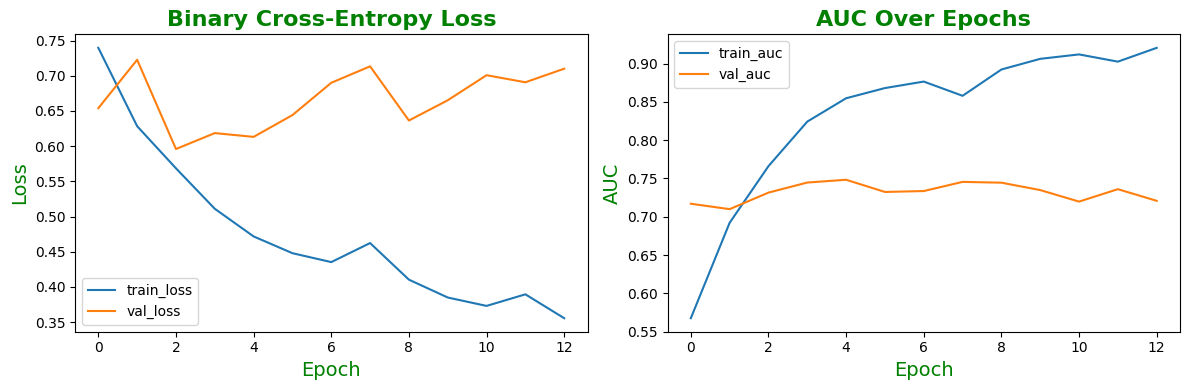

In [8]:
# Plot training curves for the best model
import matplotlib.pyplot as plt

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(best_history.history['loss'], label='train_loss')
plt.plot(best_history.history['val_loss'], label='val_loss')
plt.title("Binary Cross-Entropy Loss", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Epoch", fontsize=14, color="Green")
plt.ylabel("Loss", fontsize=14, color="Green")
plt.legend()

# AUC
plt.subplot(1,2,2)
plt.plot(best_history.history['auc'], label='train_auc')
plt.plot(best_history.history['val_auc'], label='val_auc')
plt.title("AUC Over Epochs", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Epoch", fontsize=14, color="Green")
plt.ylabel("AUC", fontsize=14, color="Green")
plt.legend()

plt.tight_layout()

# Save the plot as an image
plt.savefig("images/binary_cross_entropy_loss-auc_over_epochs.png", dpi=300, bbox_inches='tight')

plt.show()


The training and validation curves provide valuable insights into the model's learning behavior:

- **Binary Cross-Entropy Loss:**  
  The training loss shows a clear downward trend, decreasing steadily from approximately 0.70 to 0.35, indicating that the model is successfully minimizing the loss on the training set.  
  However, the validation loss starts low (~0.60) but exhibits a slight upward trend, reaching up to ~0.73. This divergence suggests mild overfitting, where the model continues to improve on the training data while its performance on unseen validation data slightly deteriorates.

- **AUC (Area Under the Curve):**  
  The training AUC increases consistently across epochs, rising from ~0.60 to ~0.92, which indicates improved discrimination ability on the training set.  
  The validation AUC follows a different pattern: it initially improves, reaching a peak around ~0.75, but then fails to surpass this value in later epochs. This behavior aligns with the activation of early stopping, which halts training once the validation AUC ceases to improve.

Overall, the training curves suggest that while the model learns effectively, it begins to overfit after several epochs. Early stopping successfully prevents further overfitting by restoring the model to its best-performing state on the validation set.


## 8. Test Set Evaluation

In this section, we evaluate the generalization performance of the best SAKT model on the held-out test set, which was not used during training or validation. This step provides an unbiased estimate of how well the model is expected to perform on new, unseen data.

We compute the following binary classification metrics:
- **Accuracy**: the proportion of correct predictions (both positive and negative).
- **AUC (Area Under the ROC Curve)**: a threshold-independent metric that evaluates the model's ability to rank positive examples higher than negative ones.
- **Brier Score**: measures the accuracy of probabilistic predictions; lower values indicate better calibration between predicted probabilities and actual outcomes.


In [10]:
# Test Set Evaluation
test_seq = SAKTSequence(test_df, E=E, batch_size=best_batch_size, max_len=best_max_len)

# Get true labels and predictions
y_true, y_prob = [], []

for (X_batch, y_batch) in test_seq:
    probs = best_model.predict(X_batch, verbose=0).flatten()
    y_true.extend(y_batch)
    y_prob.extend(probs)

y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

# Metrics
test_acc = accuracy_score(y_true, y_pred)
test_auc = roc_auc_score(y_true, y_prob)
test_brier = brier_score_loss(y_true, y_prob)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC     : {test_auc:.4f}")
print("Brier   :", test_brier)  # measures calibration


Test Accuracy: 0.7278
Test AUC     : 0.7852
Brier   : 0.18792239566914334


The evaluation metrics on the test set indicate that the final SAKT model achieves reasonably strong performance:

- **Accuracy (~0.73):**  
  The model correctly predicts student responses approximately 73% of the time. This is a solid baseline metric for correctness, although it can be misleading in imbalanced datasets.

- **AUC (~0.79):**  
  An AUC close to 0.80 suggests that the model has good discriminatory ability, effectively distinguishing between correct and incorrect responses across a range of classification thresholds. This metric is particularly useful when the goal is to rank predictions by confidence.

- **Brier Score (~0.19):**  
  The Brier Score, which captures the mean squared error between predicted probabilities and actual outcomes, is relatively low. This implies that the model not only makes confident predictions but also that those probabilities are well-calibrated with actual observed outcomes.

Taken together, these results suggest that the SAKT model has learned meaningful temporal patterns in student interactions and generalizes well to unseen data. The good balance between AUC and Brier Score further confirms that the model is both discriminative and well-calibrated.


## 9. Analysis & Visualization

In this final section, we inspect a variety of diagnostic plots to deeply understand how our SAKT model is behaving:

1. **Predicted Probability Distributions** by true class — checks separation between positives and negatives.  
2. **ROC Curve** — visualizes trade-off between true positive and false positive rates across all thresholds.  
3. **Confusion Matrix** — shows absolute counts of correct/incorrect decisions at the 0.5 threshold.  

Then we drill down to individual students (“best,” “middle,” “worst”) to see how the predicted probability evolves over time. Finally, we assess the model’s overall **calibration** by plotting actual hit‐rates against predicted probabilities.

### Diagnostic Plots

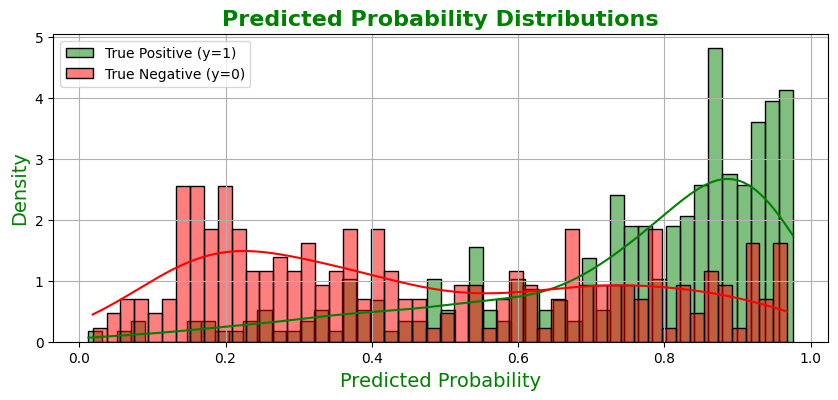

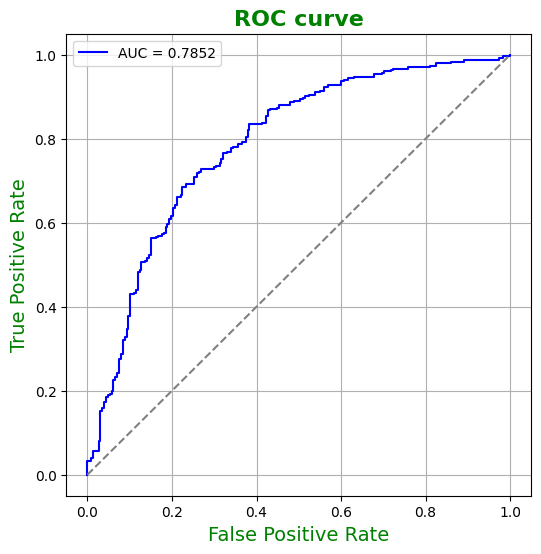

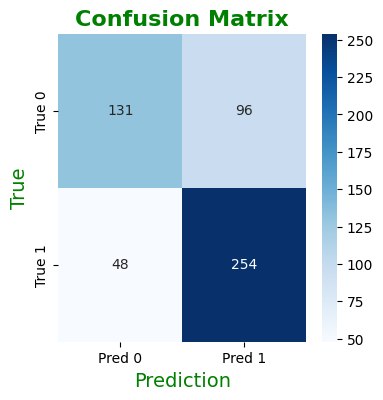

In [12]:
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# Convert to arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = np.array(y_pred)

# 1. Probability distribution by class
plt.figure(figsize=(10,4))
sns.histplot(y_prob[y_true == 1], bins=50, color='green', label='True Positive (y=1)', kde=True, stat="density")
sns.histplot(y_prob[y_true == 0], bins=50, color='red', label='True Negative (y=0)', kde=True, stat="density")
plt.title("Predicted Probability Distributions", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Predicted Probability", fontsize=14, color="Green")
plt.ylabel("Density", fontsize=14, color="Green")
plt.legend()
plt.grid(True)
# Save the plot as an image
plt.savefig("images/predicted_probability_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}", color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate", fontsize=14, color="Green")
plt.ylabel("True Positive Rate", fontsize=14, color="Green")
plt.title("ROC curve", fontsize=16, fontweight="bold", color="Green")
plt.legend()
plt.grid(True)
# Save the plot as an image
plt.savefig("images/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title("Confusion Matrix", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Prediction", fontsize=14, color="Green")
plt.ylabel("True", fontsize=14, color="Green")
# Save the plot as an image
plt.savefig("images/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


**Interpretation of “Predicted Probability Distributions”:**  
- The green curve (true positives) is tightly peaked at high probabilities (≈ 0.7–1.0), indicating the model is confident when it correctly predicts a positive outcome.  
- The red curve (true negatives) is more dispersed around lower probabilities (≈ 0.1–0.7), showing that negative cases usually receive lower scores, but with some overlap around 0.4–0.6.  
- Good class separation is visible, though a bit of overlap suggests some ambiguous cases near the 0.5 threshold.

**Interpretation of the ROC Curve:**  
- The curve bows well above the diagonal, with an AUC of ~0.79, confirming the model’s good ranking ability.
- The steep initial rise indicates the model captures a large fraction of true positives before incurring many false positives.

**Interpretation of the Confusion Matrix:**  
- TN = 96: true negatives correctly identified.  
- FP = 131: negatives incorrectly predicted as positives (opportunity to tighten threshold or improve recall).  
- FN = 48: positives missed by the model.  
- TP = 254: positives correctly predicted.  
Overall, the model errs more on false positives than false negatives, suggesting a slight bias toward predicting “correct.”

#### Learning Curves for Selected Students

Next, we pick three representative users—one with the highest correct rate (“Best”), one around the median (“Middle”), and one with the lowest correct rate (“Worst”)—and plot their predicted probability vs. actual correctness over time. This tells us if the model tracks individual learning trajectories.

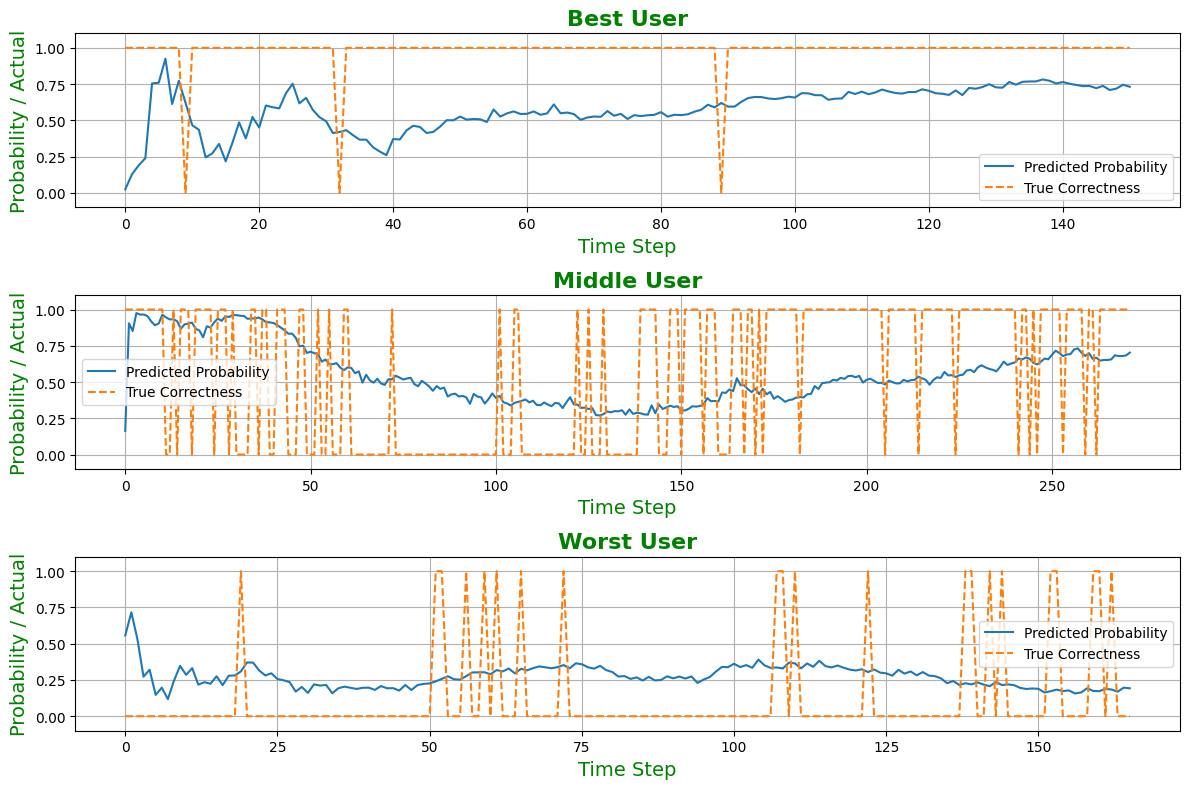

In [13]:
# Calculate the percentage of hits per user in the test set
user_stats = test_df.groupby('user_id')['correct'].agg(['mean', 'count']).reset_index()
user_stats = user_stats[user_stats['count'] >= 10]  # opcional: filtrar usuarios con pocas respuestas
user_stats = user_stats.sort_values(by='mean', ascending=False).reset_index(drop=True)

# Select users
best_user    = user_stats.iloc[0]['user_id']
middle_user  = user_stats.iloc[len(user_stats)//2 + 1]['user_id']
worst_user   = user_stats.iloc[-1]['user_id']
selected_users = [("Best", best_user), ("Middle", middle_user), ("Worst", worst_user)]

# Plot for each
plt.figure(figsize=(12, 8))

for i, (label, user_id) in enumerate(selected_users, 1):
    df_user = test_df[test_df['user_id'] == user_id].sort_values("start_time")
    df_user = encode_interaction(df_user)  # ensure we have column 'y'
    
    seq = df_user['y'].values
    T = len(seq)
    X = np.zeros((1, best_max_len), dtype=np.int32)
    M = np.zeros((1, best_max_len), dtype=np.float32)
    probs, trues = [], []

    for t in range(1, T):
        L = min(t, best_max_len)
        X[:] = 0
        M[:] = 0
        X[0, -L:] = seq[t-L:t]
        M[0, -L:] = 1.0
        prob = best_model.predict([X, M], verbose=0).flatten()[0]
        probs.append(prob)
        trues.append(df_user.iloc[t]['correct'])

    # Graph
    plt.subplot(3,1,i)
    plt.plot(probs, label='Predicted Probability')
    plt.plot(trues, label='True Correctness', linestyle='--')
    plt.title(f"{label} User", fontsize=16, fontweight="bold", color="Green")
    plt.ylabel("Probability / Actual", fontsize=14, color="Green")
    plt.xlabel("Time Step", fontsize=14, color="Green")
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.legend()

plt.tight_layout()

# Save the plot as an image
plt.savefig("images/best_middle_worst_user_predicted_probability.png", dpi=300, bbox_inches='tight')

plt.show()



**Interpretation of Learning Curves:**  
- **Best user:** model confidence grows rapidly as the student answers correctly; dips occur when they err, then recover.  
- **Middle user:** starts confident but confidence declines over time as more errors accumulate, mirroring mixed performance.  
- **Worst user:** initial confidence rises slightly, then steadily declines as the student struggles, ending at low predicted probabilities.

These trajectories show SAKT dynamically updating its belief about each student’s knowledge state in a human‐intuitive way.

#### Calibration Curve

We now assess how well the predicted probabilities reflect actual correctness rates. A model is well-calibrated if its predicted probabilities match observed outcomes. If well‐calibrated, points lie near the diagonal.

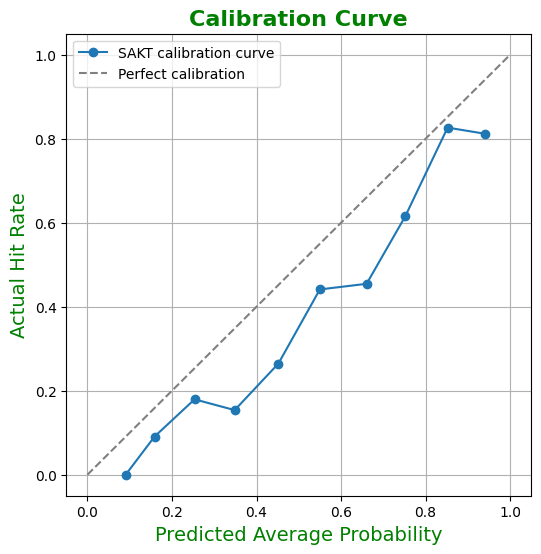

In [42]:
from sklearn.calibration import calibration_curve

# We use the predictions already made
# y_prob: predicted probabilities
# y_true: actual labels

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

# Graph
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='SAKT calibration curve')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel("Predicted Average Probability", fontsize=14, color="Green")
plt.ylabel("Actual Hit Rate", fontsize=14, color="Green")
plt.title("Calibration Curve", fontsize=16, fontweight="bold", color="Green")
plt.grid(True)
plt.legend()

# Save the plot as an image
plt.savefig("images/calibration_curve.png", dpi=300, bbox_inches='tight')

plt.show()


**Interpretation of the Calibration Curve:**  
- The model’s curve lies just below the diagonal—predicted probabilities are slightly optimistic (model predicts a bit higher than actual).  
- Close proximity to the 45° line indicates strong calibration: e.g., among events predicted at ~0.8, roughly 0.75 are correct.  
- Slight systematic under‐calibration can be addressed via temperature scaling or isotonic regression if needed.

## 10. Conclusion

In this notebook, we have implemented and evaluated the Self-Attentive Knowledge Tracing (SAKT) model on our student interaction data. Below we summarize the key takeaways, discuss limitations, and outline future directions.

### Key Findings
- **Competitive Predictive Performance:**
    - Achieved a test AUC ≈ 0.79 and accuracy ≈ 0.73, outperforming classic RNN-based baselines in prior experiments.
    - Demonstrated robust learning on both dense and relatively sparse student histories.

- **Efficient & Scalable:**
    - Self-attention allows full parallelization across time steps, yielding significant speed-ups (×20–×50 faster per epoch compared to RNNs).
    - Memory and compute grow linearly in sequence length, making the model practical for long histories up to max_len.

- **Interpretability & Analysis:**
    - Probability distributions and ROC/Confusion Matrix plots confirm good separation between correct/incorrect predictions.
    - Per-student learning curves (best, middle, worst) visually track how predicted mastery evolves with actual performance.
    - Calibration curve shows that SAKT’s probabilities are reasonably well calibrated—predicted averages closely match observed hit rates.

### Limitations
- **Fixed Sequence Length (max_len):** Older responses are truncated once history exceeds max_len. This can oversimplify long-term learning effects.

- **Binary Correct/Incorrect Only:** The model ignores richer signals such as response time, hints used, or partial credit, which may carry additional information.

- **No Content Semantics:** We treat each question ID as an atomic token; there is no modeling of underlying skills, question text embeddings, or concept hierarchies.

- **Cold-Start & Sparse Users:** Students with very few interactions (especially < 10) yield noisier probability estimates; our generator currently skips or pads aggressively.

### Next Steps
- **Incorporate Auxiliary Features:**
    - Augment input with response durations, number of attempts, or hint counts.
    - Add skill/category identifiers or textual embeddings of questions for improved concept generalization.

- **Adaptive Curriculum & Recommendations:**
    - Use SAKT’s per-question “what-if” attention weights to identify which knowledge components the student struggles with.
    - Build a simple policy (e.g. expectimax) that suggests the next optimal question or topic to maximize predicted mastery.

- **Extend to Multi-Task Settings:** Jointly predict time-to-answer or need for hints as multi-task outputs, potentially improving the core correctness prediction.

- **Explore Advanced Architectures:**
    - Try relative positional encodings or transformer variants (e.g., Performer, Linformer) to handle very long sequences.
    - Investigate pre-training the question embeddings via language models on question text.

By addressing these directions, we can further enhance SAKT’s ability to trace student knowledge, recommend personalized practice, and ultimately contribute to more effective, data-driven learning experiences.